In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
!pip install pydlm
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pydlm import dlm, trend, dynamic
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.0 MB/s eta 0:00:00


In [3]:
# 2. Đọc file dữ liệu và chia train test validate theo tỉ lệ
df = pd.read_csv('/content/drive/MyDrive/Project_dataset/HPG.csv')
df = df[['Price','Low']]

df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validating sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

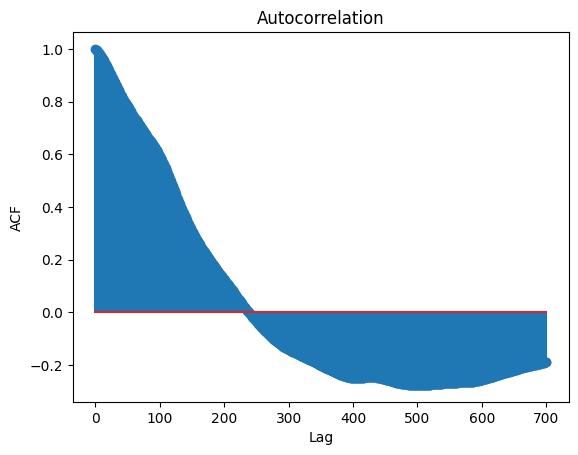

In [4]:
# 3. Tính toán ACF
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data['Price'], nlags= 700)

# Vẽ đồ thị ACF
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation')
plt.show()

In [5]:
# 4. Quá trình training
y_train = np.array(train_data['Price'])

x_train = []
for data in train_data['Low']:
  x_train.append([data])

model = dlm(y_train)
model = model + trend(1, discount=0.99, name='Trend', w=1e7)
model = model + dynamic(features=x_train, discount=1, name='Low')
model = model + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model = model + longSeason(period=12, stay=30, data=y_train, name='season', w=1e7)


model.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [6]:
# 5. Quá trình testing
x_test= []
for data in test_data['Low']:
  x_test.append([data])

y_test = np.array(test_data['Price'])

y_pred = model.predictN(date = model.n-1, N=len(x_test),featureDict={'Low': x_test})
y_pred = y_pred[0]


In [7]:
# 6. Quá trình Validate
x_val= []
for data in val_data['Low']:
  x_val.append([data])

y_val = np.array(val_data['Price'])

y_pred_val = model.predictN(featureDict={'Low': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]


In [8]:
# 7. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 7866.827901147015
Testing RMSE: 7337.69777422171
Validation MAPE: 38.278238304898466
Testing MAPE: 29.17261523328473
Validation MAE: 7842.475144443203
Testing MAE: 6003.245170578538


In [9]:
#  8. Sử dụng linear regression dự báo cột Low 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])


# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

index_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
low_next_30_days = ln_model.predict(index_next_30_days)

print(low_next_30_days)


[43177.66564266 43208.93852077 43240.21139889 43271.484277
 43302.75715512 43334.03003323 43365.30291135 43396.57578946
 43427.84866758 43459.12154569 43490.39442381 43521.66730192
 43552.94018004 43584.21305815 43615.48593627 43646.75881438
 43678.0316925  43709.30457061 43740.57744872 43771.85032684
 43803.12320495 43834.39608307 43865.66896118 43896.9418393
 43928.21471741 43959.48759553 43990.76047364 44022.03335176
 44053.30622987 44084.57910799]


In [10]:
# 9. Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days = []
for data in low_next_30_days:
  x_next_30_days.append([data])

y_next_30_days = model.predictN(N = 30, featureDict={'Low': x_next_30_days})
y_next_30_days = y_next_30_days[0]
print(y_next_30_days)


[41821.058001643854, 40195.15875701343, 41120.77639953958, 40631.31006360343, 40945.945474232685, 40829.203636743936, 40947.82763047402, 40937.79345249706, 40997.876876220434, 41019.715816486496, 41062.417189567415, 41093.73984610991, 41131.268880552, 41165.412697403364, 41201.402938330015, 41236.38606882849, 41271.91851620072, 41307.15134508627, 41342.54759739678, 41377.85471229499, 41413.210446160185, 41448.53966137402, 41483.88334087853, 41519.21913100354, 41554.55922429905, 41282.08157234113, 41425.65485092142, 41403.00351030574, 41472.61841395929, 41489.731459060575]


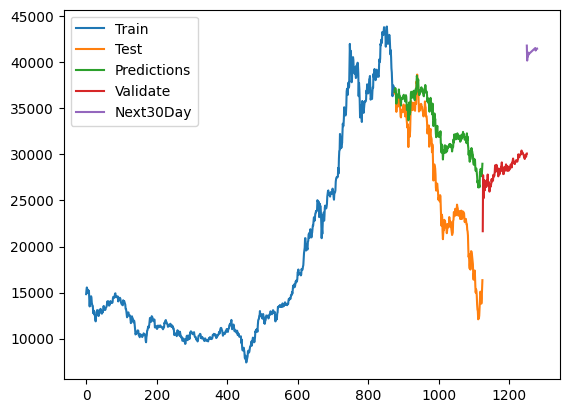

In [11]:
# 10. Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()